## Sampler CMB

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from chainconsumer import ChainConsumer
# our own modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.likelihood import likelihood
from lace_manager.sampler import emcee_sampler
import time

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                sim_label=test_sim_label,
                                zmax=z_max)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [5]:
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
kmax_Mpc=8
emu_type="polyfit"
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
Optimised


In [6]:
free_param_limits=[[0.0099,0.0109],[1.1e-09,3.19e-09],[-0.2, 0.2]]
free_param_names=["cosmomc_theta","A_s","ln_tau_0"]
assert len(free_param_limits)==len(free_param_names)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [8]:
free_param_limits=[[0.0099,0.0109],[1.1e-09,3.19e-09],[-0.2, 0.2]]
free_param_names=["cosmomc_theta","As","ln_tau_0"]
assert len(free_param_limits)==len(free_param_names)
prior=0.5
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior,
                            include_CMB=True,verbose=False)

free param limits [[0.0099, 0.0109], [1.1e-09, 3.19e-09], [-0.2, 0.2]]
free param names ['cosmomc_theta', 'As', 'ln_tau_0']
3 3


### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [9]:
## Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,verbose=False,
                        nwalkers=10,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)

In [10]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

cosmomc_theta 0.010392466823954094 0.0099 0.0109
As 2.1e-09 1.1e-09 3.19e-09
ln_tau_0 0.0 -0.2 0.2


In [11]:
n_burn_in=20
n_steps=200 ## Max number of steps to run

start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|█████████████████████████████████████████| 220/220 [27:43<00:00,  7.56s/it]

Sampling took 1665.3 seconds


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:381: FutureWarning:elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


will keep 1751 \ 2000 points from chain


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/lace_manager-1.0.1-py3.8.egg/lace_manager/sampler/emcee_sampler.py:802: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


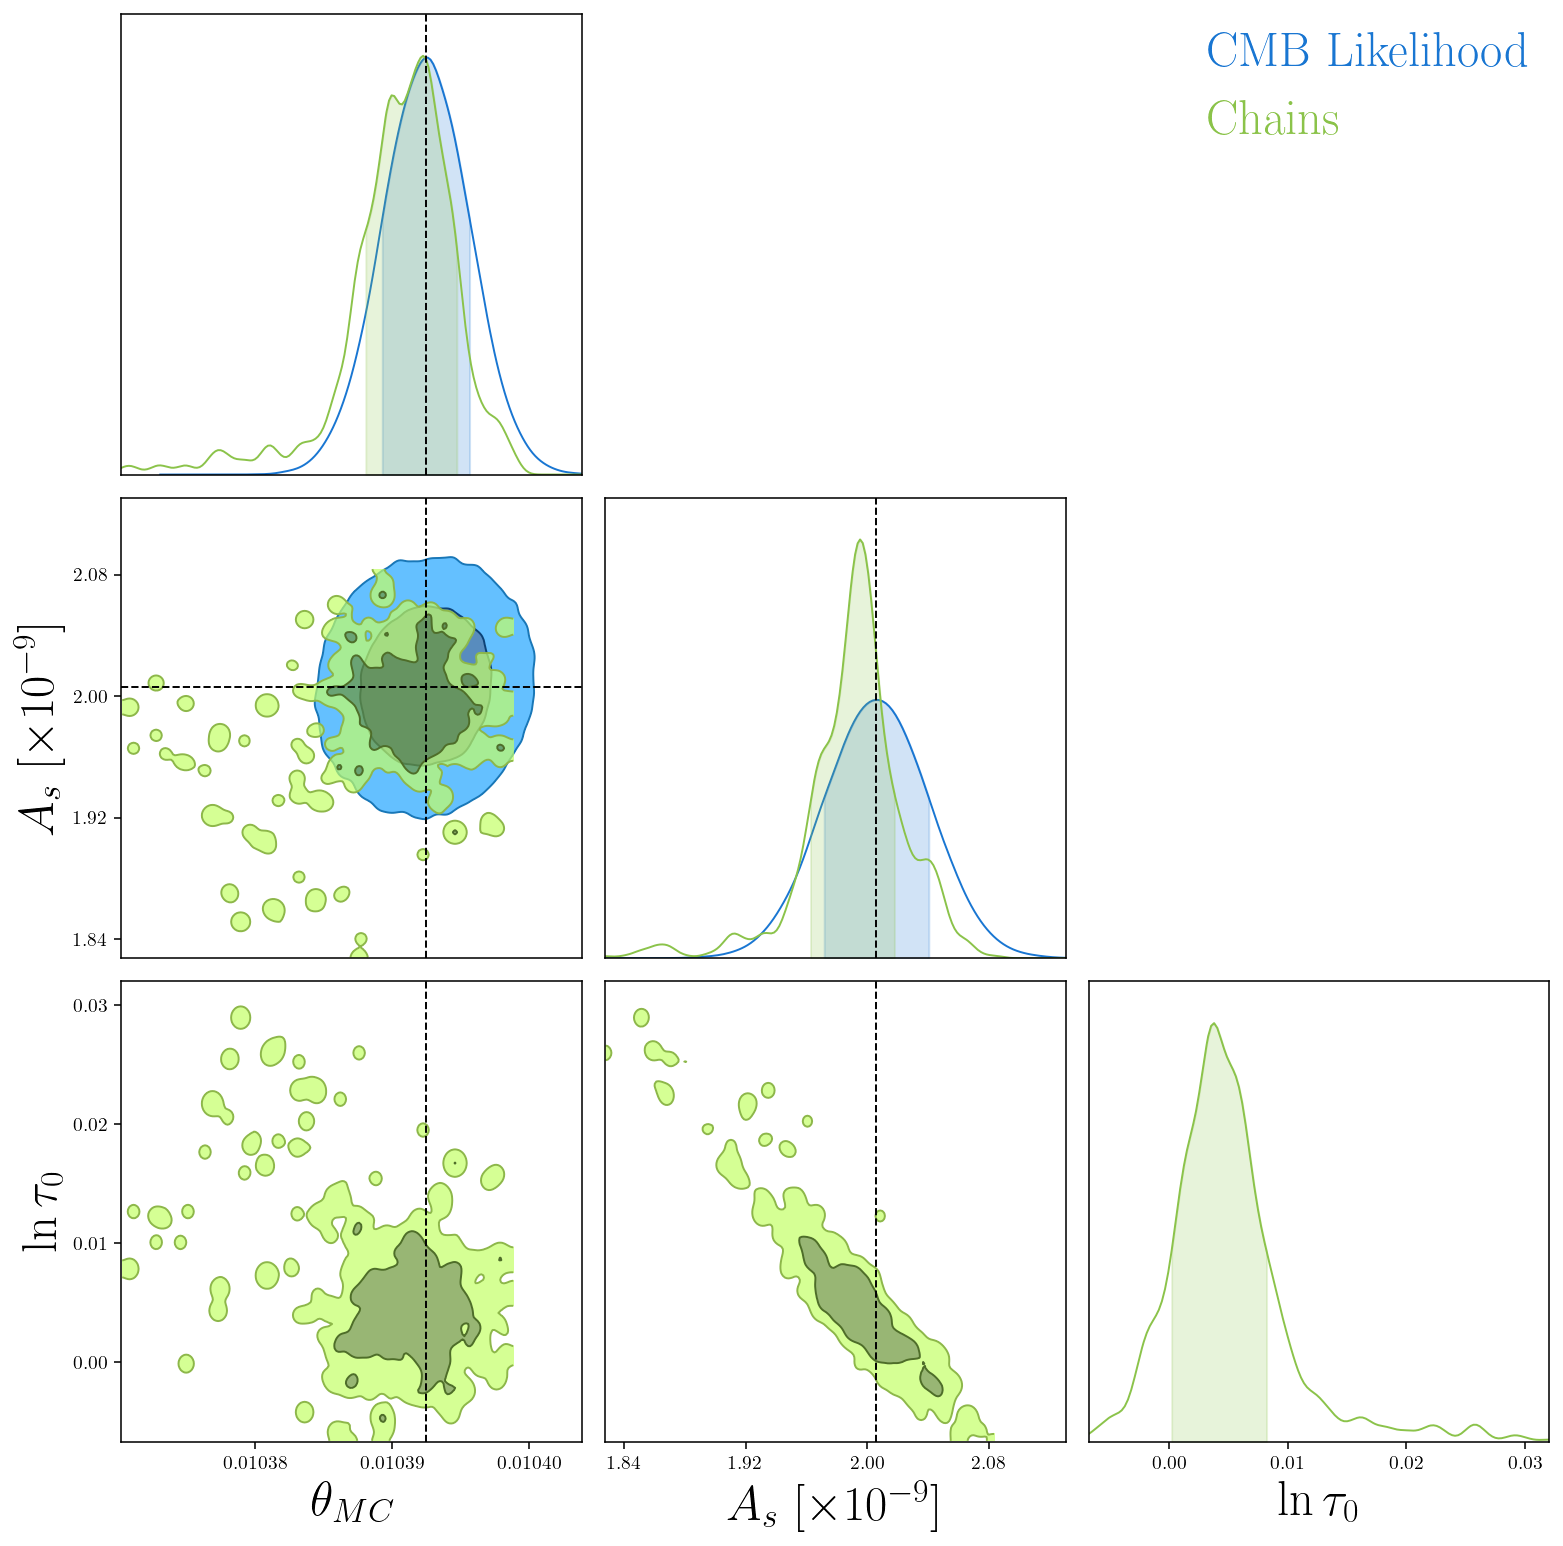

In [12]:
sampler.plot_corner(cmb_prior=True,delta_lnprob_cut=50)

Mean values: [0.48879318927731824, 0.4281104467992061, 0.5195737894325216]


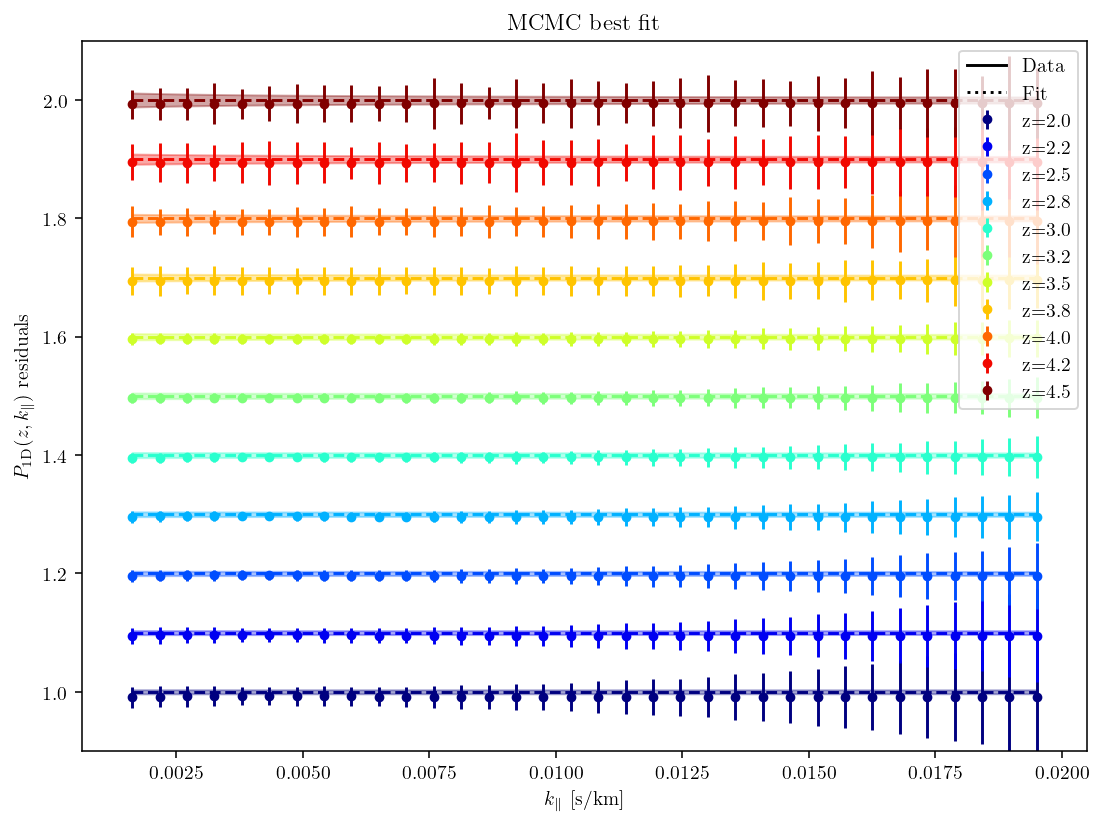

In [13]:
sampler.plot_best_fit(residuals=True)